# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Data Loading

In [3]:
# Import the data into variable for ease to use
df = pd.read_csv("data/jobs.csv", index_col=False)
df.head()

,Unnamed: 0,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,0,31/10/2024,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...
1,1,14/3/2025,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer
2,2,9/4/2025,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer
3,3,22/3/2025,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training"
4,4,28/3/2025,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer


In [4]:
# Check the columns name
df.columns.tolist()

['Unnamed: 0',
 'job_posted_date',
 'company_address_locality',
 'company_address_region',
 'company_name',
 'company_website',
 'company_description',
 'job_description_text',
 'seniority_level',
 'job_title']

In [5]:
# Drop those columns without labels
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,31/10/2024,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...
1,14/3/2025,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer
2,9/4/2025,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer
3,22/3/2025,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training"
4,28/3/2025,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer


# Data Understanding

In [6]:
# Check the size of the data
df.shape

(997, 9)

In [7]:
# Check null value
df.isnull().sum()

job_posted_date               0
company_address_locality     47
company_address_region      113
company_name                  0
company_website              14
company_description          12
job_description_text          1
seniority_level               9
job_title                     0
dtype: int64

In [8]:
# Check duplicate value
df.duplicated().sum()

157

In [9]:
df.dtypes 

job_posted_date             object
company_address_locality    object
company_address_region      object
company_name                object
company_website             object
company_description         object
job_description_text        object
seniority_level             object
job_title                   object
dtype: object

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Mid-Senior level'),
  Text(1, 0, 'Entry level'),
  Text(2, 0, 'Not Applicable'),
  Text(3, 0, 'Internship'),
  Text(4, 0, 'Associate'),
  Text(5, 0, 'Director'),
  Text(6, 0, 'Executive')])

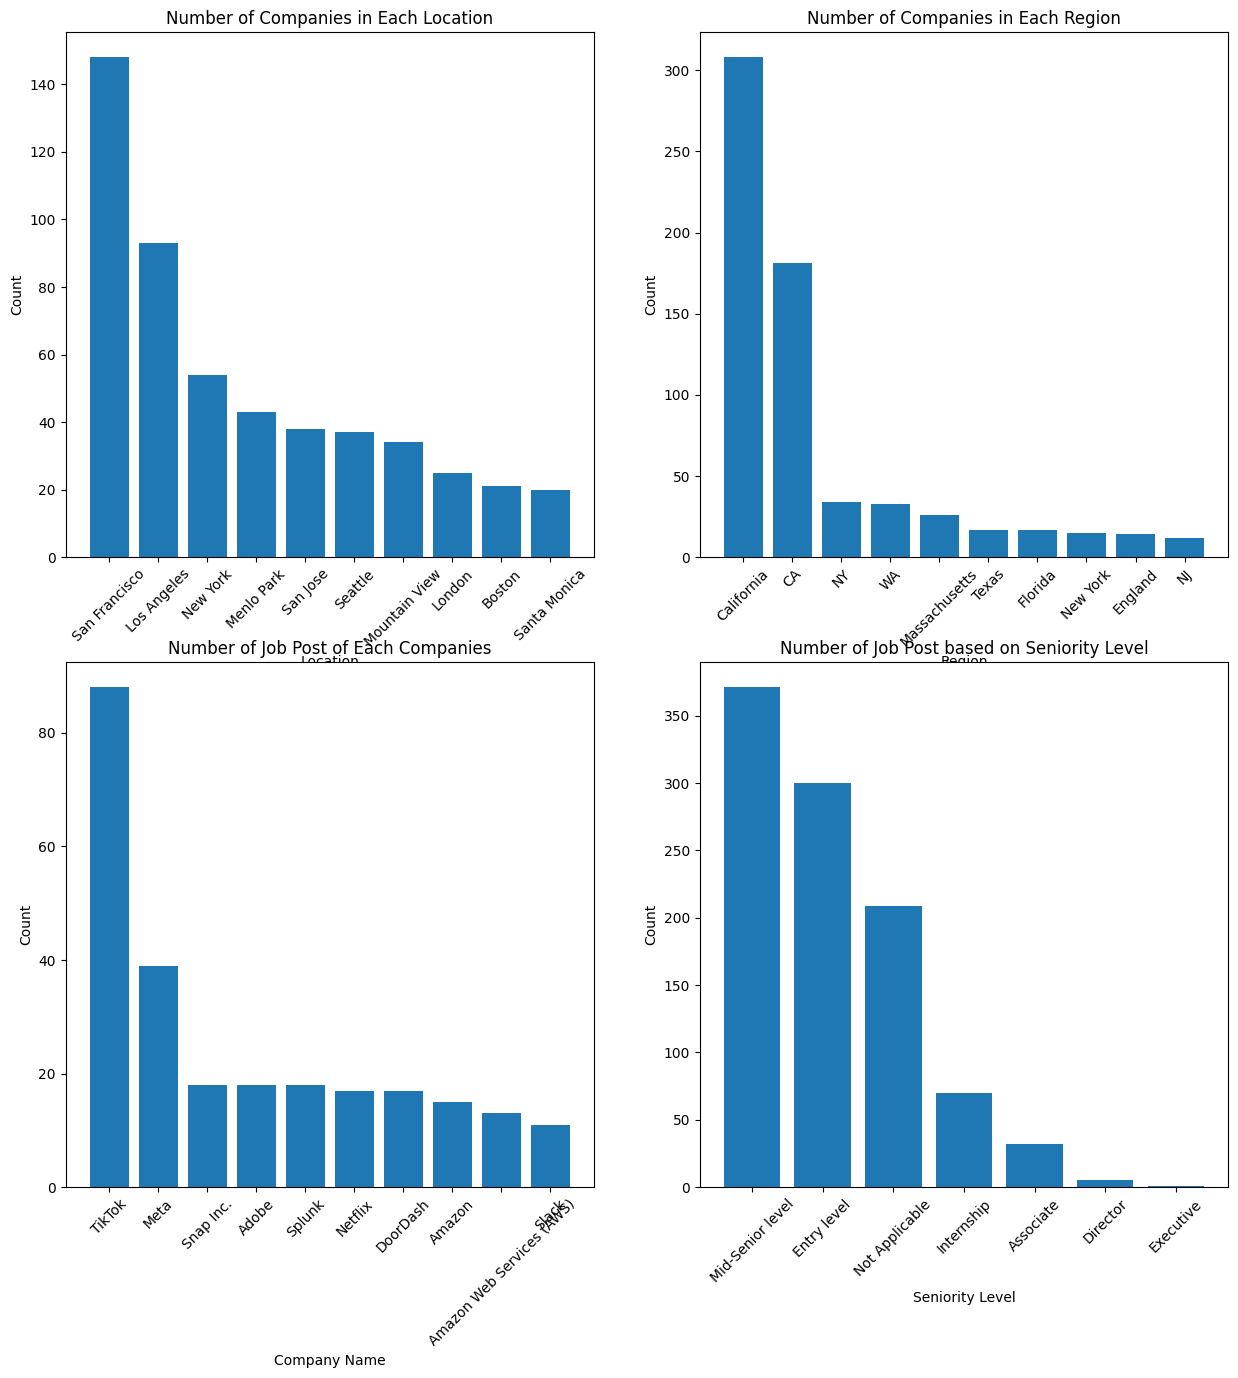

In [10]:
# Check the number of the data for location, region, name and seniority level
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
location_count = df["company_address_locality"].value_counts().head(10)
plt.bar(location_count.index, location_count.values)
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Number of Companies in Each Location")
plt.xticks(rotation=45)

plt.subplot(2,2,2)
region_count = df["company_address_region"].value_counts().head(10)
plt.bar(region_count.index, region_count.values)
plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Number of Companies in Each Region")
plt.xticks(rotation=45)

plt.subplot(2,2,3)
name_count = df["company_name"].value_counts().head(10)
plt.bar(name_count.index, name_count.values)
plt.xlabel("Company Name")
plt.ylabel("Count")
plt.title("Number of Job Post of Each Companies")
plt.xticks(rotation=45)

plt.subplot(2,2,4)
seniority_count = df["seniority_level"].value_counts()
plt.bar(seniority_count.index, seniority_count.values)
plt.xlabel("Seniority Level")
plt.ylabel("Count")
plt.title("Number of Job Post based on Seniority Level")
plt.xticks(rotation=45)

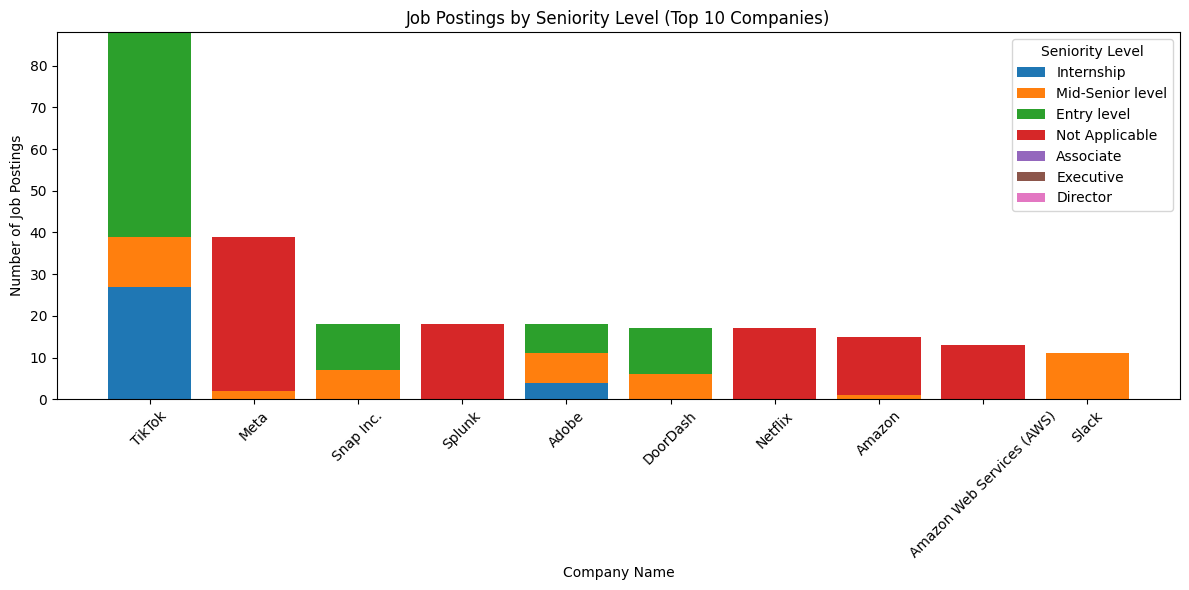

In [11]:
# Get seniority level information
seniority_levels = df["seniority_level"].unique()  
seniority_counts = df["seniority_level"].value_counts() 

# Create a dataframe for the group of company name and seniority level
company_seniority = df.groupby(['company_name', 'seniority_level']).size().unstack(fill_value=0)

# Get top N companies
top_companies = 10 
company_seniority_sorted = company_seniority.sum(axis=1).sort_values(ascending=False).head(top_companies)
company_seniority_top = company_seniority.loc[company_seniority_sorted.index]

# Plotting
plt.figure(figsize=(12, 6))
bottom = np.zeros(top_companies)

for level in seniority_levels:  
    if level in company_seniority_top.columns:
        counts = company_seniority_top[level]
        plt.bar(company_seniority_top.index, counts, bottom=bottom, label=level)
        bottom += counts

plt.xlabel('Company Name')
plt.ylabel('Number of Job Postings')
plt.title(f'Job Postings by Seniority Level (Top {top_companies} Companies)')
plt.xticks(rotation=45)
plt.legend(title='Seniority Level')
plt.tight_layout()
plt.show()

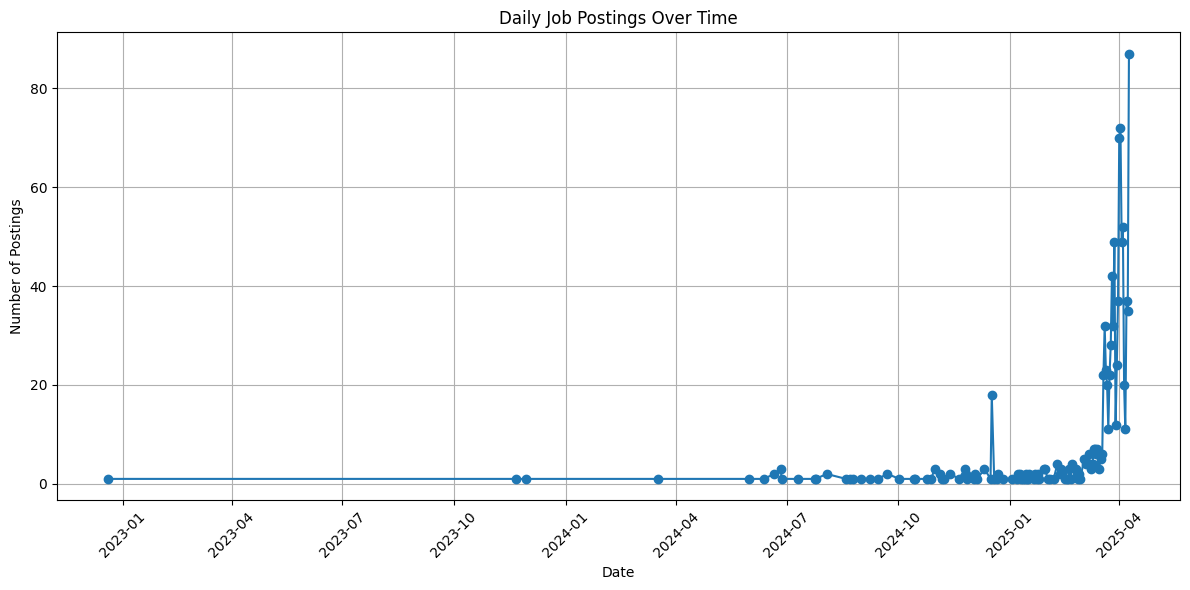

In [12]:
# Visualize the Job Postings over time
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'], dayfirst=True)
df = df.sort_values('job_posted_date')

# Count posts by date
ts_data = df['job_posted_date'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data.values, marker='o', linestyle='-')
plt.title('Daily Job Postings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Postings')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

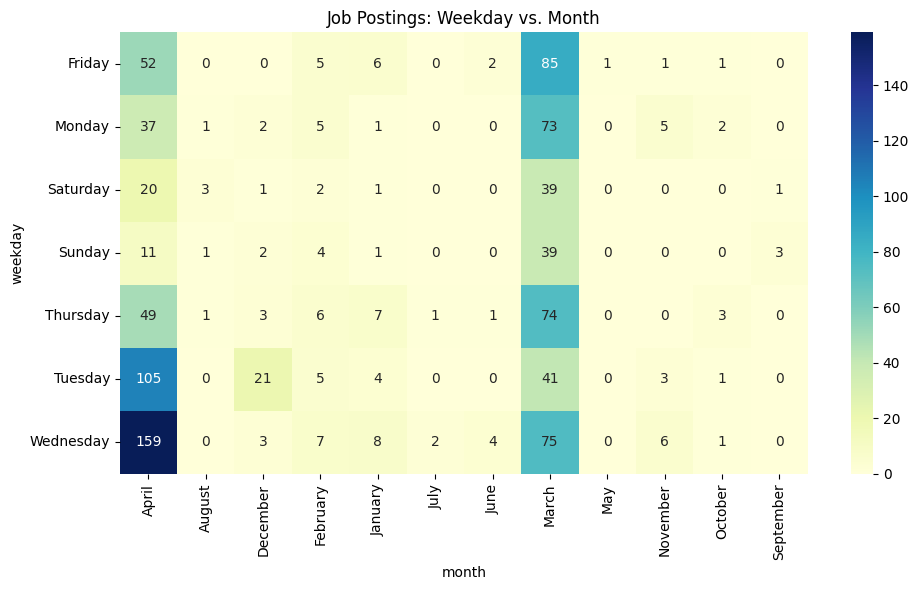

In [13]:
# Extract weekday and month
df['weekday'] = df['job_posted_date'].dt.day_name()
df['month'] = df['job_posted_date'].dt.month_name()

# Pivot table
heatmap_data = df.pivot_table(index='weekday', 
                             columns='month', 
                             aggfunc='size', 
                             fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Job Postings: Weekday vs. Month')
plt.tight_layout()
plt.show()

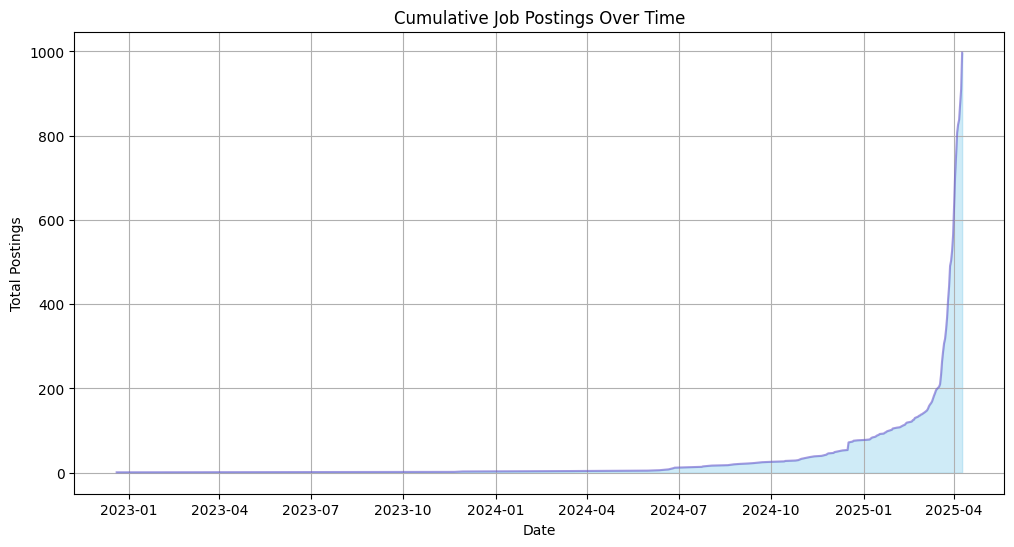

In [14]:
plt.figure(figsize=(12, 6))
plt.fill_between(ts_data.index, ts_data.cumsum(), color='skyblue', alpha=0.4)
plt.plot(ts_data.index, ts_data.cumsum(), color='Slateblue', alpha=0.6)
plt.title('Cumulative Job Postings Over Time')
plt.xlabel('Date')
plt.ylabel('Total Postings')
plt.grid(True)
plt.show()

# Data Cleaning

In [15]:
# Clean the null values
df.dropna(inplace=True)

In [16]:
# Clean the duplicate data
df = df.drop_duplicates()

In [17]:
df.head()

,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,weekday,month
362,2022-12-20,New York,NY,OXMAN,https://oxman.com/,Envision a future of complete synergy between ...,OXMANOXMAN is a hybrid Design and R&amp;D comp...,Not Applicable,Machine Learning Engineer,Tuesday,December
119,2023-11-21,San Francisco,California,Kaedim,https://www.kaedim3d.com,Kaedim's machine learning and in-house art tea...,"Hi there! My name is Konstantina, I’m the foun...",Entry level,Machine Learning Engineer,Tuesday,November
562,2024-03-17,New York,New York,Hang,http://hang.com,Agent-Powered CX,Hang is building the future of loyalty for bra...,Entry level,Machine Learning Engineer,Sunday,March
962,2024-05-31,Miami,Florida,Maverc Technologies,http://Www.Maverc.com,"Maverc brings proven operational excellence, f...",Become part of a team solving the most signifi...,Mid-Senior level,Senior Machine Learning Engineer,Friday,May
512,2024-06-21,San Francisco,CA,Dashworks,https://www.dashworks.ai,Dashworks AI unlocks your company’s internal k...,About DashworksDashworks is an intelligent ass...,Mid-Senior level,Software Engineer - Machine Learning,Friday,June


# Feature Selection

### Correlation Matrix

In [18]:
# Make a copy for the cleaned data
corr_df = df.copy()

In [19]:
# Drop the unused columns
corr_df.drop(columns=['job_posted_date'], inplace=True)
corr_df.head()

,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,weekday,month
362,New York,NY,OXMAN,https://oxman.com/,Envision a future of complete synergy between ...,OXMANOXMAN is a hybrid Design and R&amp;D comp...,Not Applicable,Machine Learning Engineer,Tuesday,December
119,San Francisco,California,Kaedim,https://www.kaedim3d.com,Kaedim's machine learning and in-house art tea...,"Hi there! My name is Konstantina, I’m the foun...",Entry level,Machine Learning Engineer,Tuesday,November
562,New York,New York,Hang,http://hang.com,Agent-Powered CX,Hang is building the future of loyalty for bra...,Entry level,Machine Learning Engineer,Sunday,March
962,Miami,Florida,Maverc Technologies,http://Www.Maverc.com,"Maverc brings proven operational excellence, f...",Become part of a team solving the most signifi...,Mid-Senior level,Senior Machine Learning Engineer,Friday,May
512,San Francisco,CA,Dashworks,https://www.dashworks.ai,Dashworks AI unlocks your company’s internal k...,About DashworksDashworks is an intelligent ass...,Mid-Senior level,Software Engineer - Machine Learning,Friday,June


In [20]:
# Check for the data types for each columns
corr_df.dtypes

company_address_locality    object
company_address_region      object
company_name                object
company_website             object
company_description         object
job_description_text        object
seniority_level             object
job_title                   object
weekday                     object
month                       object
dtype: object

In [21]:
# Put the columns name into a list for ease to use
selected_columns = corr_df.columns.tolist()
print(selected_columns)

['company_address_locality', 'company_address_region', 'company_name', 'company_website', 'company_description', 'job_description_text', 'seniority_level', 'job_title', 'weekday', 'month']


In [22]:
# Encode all the categorical columns
le = LabelEncoder()

for column in selected_columns:
    corr_df[column] = corr_df[column].astype(str)
    corr_df[column] = le.fit_transform(corr_df[column])

corr_df.head()

,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,weekday,month
362,105,55,249,258,118,376,6,96,5,2
119,131,13,195,330,192,260,2,96,5,9
562,105,60,157,16,16,258,2,96,3,7
962,95,27,219,3,209,165,5,301,0,8
512,131,10,92,302,103,28,5,343,0,6


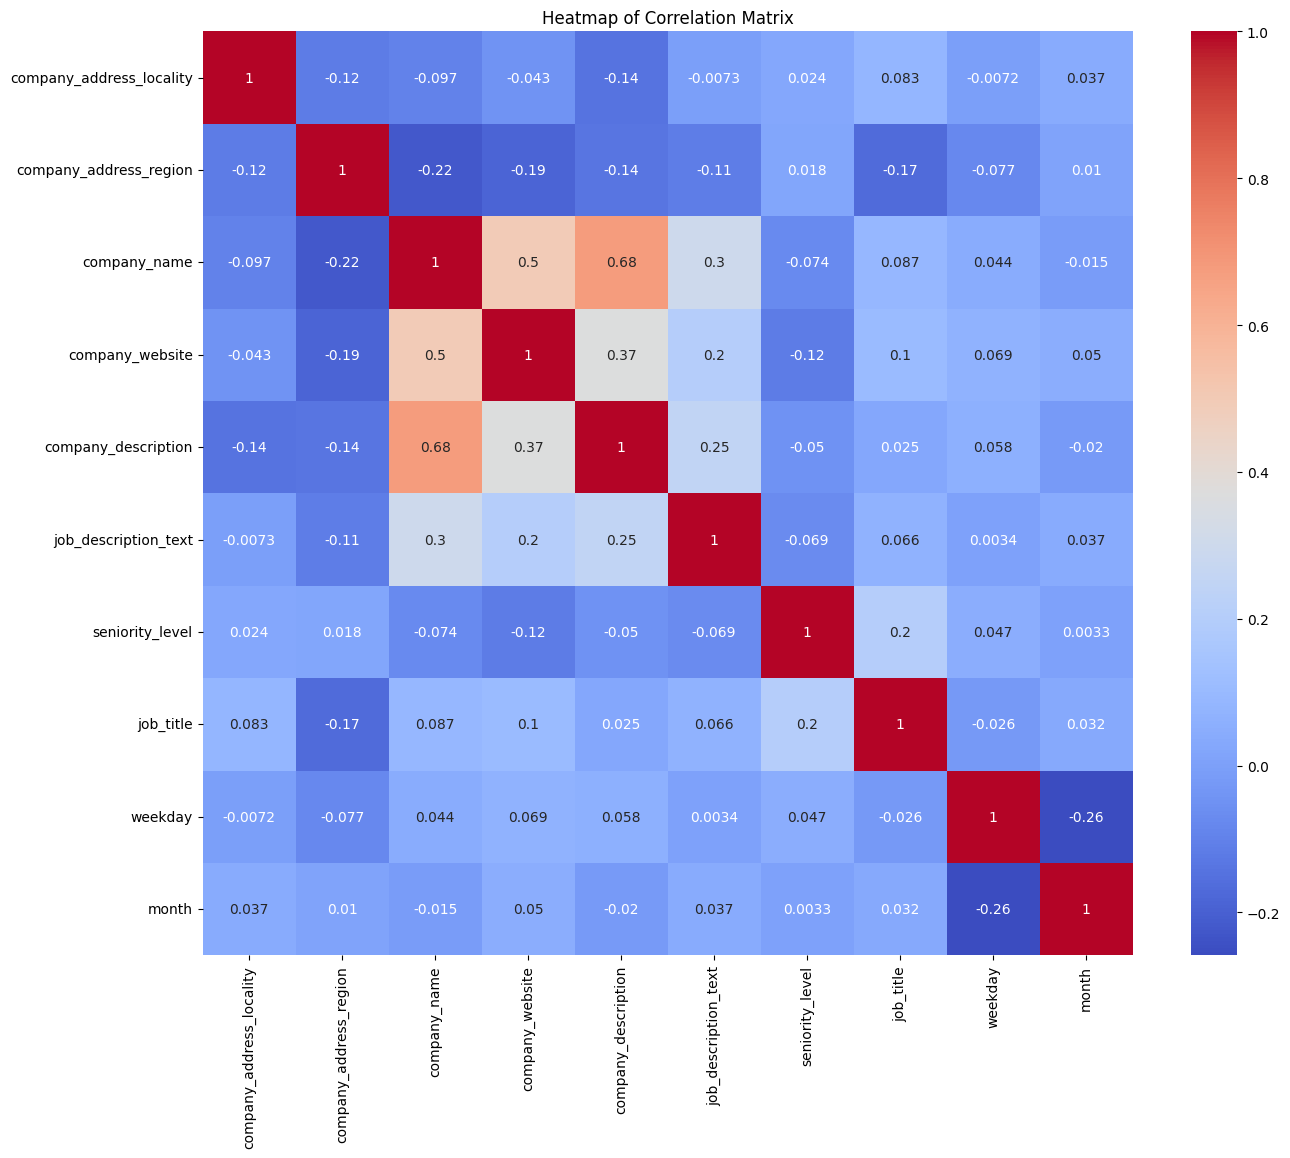

In [23]:
# Plot the correlation matrix
correlation_matrix = corr_df.corr()

plt.figure(figsize=(15,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [24]:
chosen_feature = [
    'job_title',
    'job_description_text',
    'seniority_level',
    'company_name',
    'company_address_region'
    ]

In [25]:
df = df[[
    'job_title',
    'job_description_text',
    'seniority_level',
    'company_name',
    'company_address_region'
    ]]
df.head()

,job_title,job_description_text,seniority_level,company_name,company_address_region
362,Machine Learning Engineer,OXMANOXMAN is a hybrid Design and R&amp;D comp...,Not Applicable,OXMAN,NY
119,Machine Learning Engineer,"Hi there! My name is Konstantina, I’m the foun...",Entry level,Kaedim,California
562,Machine Learning Engineer,Hang is building the future of loyalty for bra...,Entry level,Hang,New York
962,Senior Machine Learning Engineer,Become part of a team solving the most signifi...,Mid-Senior level,Maverc Technologies,Florida
512,Software Engineer - Machine Learning,About DashworksDashworks is an intelligent ass...,Mid-Senior level,Dashworks,CA


# Feature Engineering

In [26]:
# Text features
df['combined_text'] = df['job_title'] + " " + df['job_description_text']

# Vectorization
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
text_features = tfidf.fit_transform(df['combined_text'])

In [27]:
# Categorical features
encoder = OneHotEncoder()
categorical_features = encoder.fit_transform(
    df[['seniority_level', 'company_address_region']]
)

In [28]:
# Combine both features
final_features = hstack([text_features, categorical_features])

# Model Saving

In [ ]:
from scipy.sparse import save_npz
import pickle

# Save the sparse feature matrix
save_npz('data/job_features.npz', final_features)

# Save the fitted preprocessing objects
with open('data/preprocessors.pkl', 'wb') as f:
    pickle.dump({
        'tfidf': tfidf,
        'encoder': encoder,
        'feature_columns': ['job_title', 'job_description_text', 'seniority_level', 'company_address_region']
    }, f)